<a href="https://colab.research.google.com/github/Johna210/AI-Group-Project/blob/main/AssignmentIII/Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Load and Preprocess Data**

In [2]:
from keras.datasets import mnist

In [3]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Flatten the images for logistic regression
x_train_flat = x_train.reshape(-1, 28*28)
x_test_flat = x_test.reshape(-1, 28*28)


11490434/11490434 [==============================] - 1s 0us/step


In [4]:
print(f'Training set shape: {x_train.shape}, {y_train.shape}')
print(f'Test set shape: {x_test.shape}, {y_test.shape}')

Training set shape: (60000, 28, 28), (60000,)
Test set shape: (10000, 28, 28), (10000,)


# **Step 2: Feature Extraction**

### Raw Pixel Values
- Aleardy done in the flatenning step
- Simple and direct representation of images, capturing all pixel information.

### Histogram of Oriented Gradients (HOG)
- Captures the structure and edge information of images, providing a more robust feature set for digit recognition.

In [7]:
from skimage.feature import hog
import pandas as pd

def extract_hog_features(images):
    hog_features = [hog(image, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=False) for image in images]
    return hog_features

x_train_hog = extract_hog_features(x_train)
x_test_hog = extract_hog_features(x_test)

x_train_hog_df = pd.DataFrame(x_train_hog)
x_test_hog_df = pd.DataFrame(x_test_hog)

# Verify the shapes
print(f'x_train_hog_df shape: {x_train_hog_df.shape}')
print(f'x_test_hog_df shape: {x_test_hog_df.shape}')

x_train_hog_df shape: (60000, 36)
x_test_hog_df shape: (10000, 36)


### Principal Component Analysis (PCA)
- Reduces dimensionality while preserving variance, making computation more efficient and potentially improving model performance.

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

# **Step 3: Model Implimentaion**

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define hyperparameters
nb_params = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
lr_params = {'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 1.5]}

# Function to perform GridSearchCV
def perform_grid_search(model, params, x_train, y_train):
    try:
        grid_search = GridSearchCV(model, params, cv=3, scoring='accuracy')
        grid_search.fit(x_train, y_train)
        return grid_search.best_estimator_
    except Exception as e:
        print(f"Error during grid search for {model}: {e}")
        return None

# Define models
models = {
    'nb': GaussianNB(),
    'lr': LogisticRegression(max_iter=1000, solver='liblinear')
}

# Training and evaluation function
def train_and_evaluate(models, x_train, y_train, x_test, y_test, nb_params, lr_params):
    best_models = {}
    for name, model in models.items():
        if name == 'nb':
            best_models[name] = perform_grid_search(model, nb_params, x_train, y_train)
        else:
            best_models[name] = perform_grid_search(model, lr_params, x_train, y_train)

    # Evaluate on test set
    for name, model in best_models.items():
        if model:
            predictions = model.predict(x_test)
            accuracy = accuracy_score(y_test, predictions)
            print(f'{name.upper()} Model Accuracy: {accuracy:.4f}')
        else:
            print(f'{name.upper()} Model training failed.')

# Assuming you have loaded and preprocessed the MNIST data as x_train, y_train, x_test, y_test
print("Evaluating on raw pixel values:")
train_and_evaluate(models, x_train_flat, y_train, x_test_flat, y_test, nb_params, lr_params)

# Assuming you have extracted HOG features into x_train_hog, x_test_hog
print("Evaluating on HOG features:")
train_and_evaluate(models, x_train_hog, y_train, x_test_hog, y_test, nb_params, lr_params)

# Assuming you have performed PCA and got x_train_pca, x_test_pca
print("Evaluating on PCA features:")
train_and_evaluate(models, x_train_pca, y_train, x_test_pca, y_test, nb_params, lr_params)


Evaluating on raw pixel values:
NB Model Accuracy: 0.6414
LR Model Accuracy: 0.9201
Evaluating on HOG features:
NB Model Accuracy: 0.8150
LR Model Accuracy: 0.8651
Evaluating on PCA features:
NB Model Accuracy: 0.8777
LR Model Accuracy: 0.9049


In [16]:
import matplotlib.pyplot as plt

def plot_hyperparameter_variations(grid_search_results, param_name, model_name):
    means = grid_search_results.cv_results_['mean_test_score']
    stds = grid_search_results.cv_results_['std_test_score']
    params = grid_search_results.cv_results_['params']

    param_values = [param[param_name] for param in params]

    plt.figure(figsize=(8, 6))
    plt.errorbar(param_values, means, yerr=stds, fmt='-o')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.title(f'Hyperparameter Tuning for {model_name}')
    plt.xscale('log')
    plt.show()


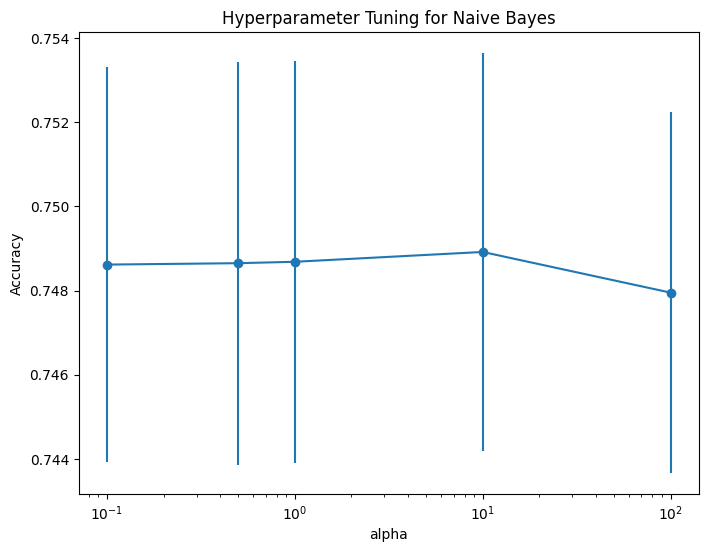

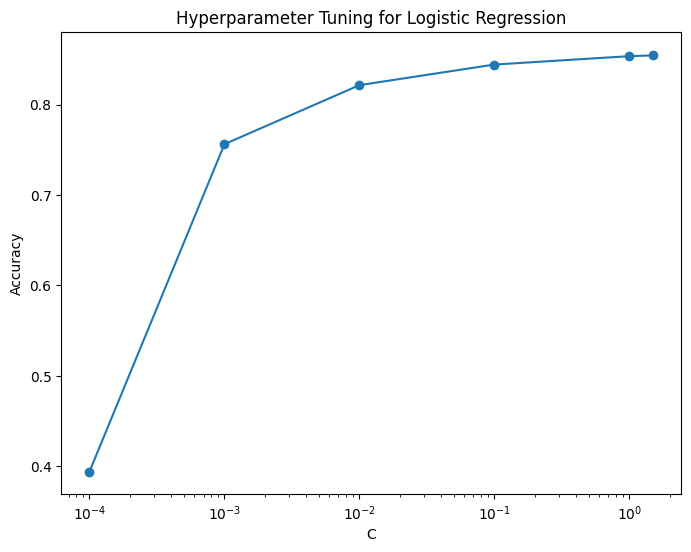

In [19]:
# Plot for Naive Bayes
nb_results = GridSearchCV(MultinomialNB(), {'alpha': [0.1, 0.5, 1.0, 10, 100]}, cv=3, scoring='accuracy').fit(x_train_hog, y_train)
plot_hyperparameter_variations(nb_results, 'alpha', 'Naive Bayes')

# Plot for Logistic Regression
lr_results = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=3, scoring='accuracy').fit(x_train_hog, y_train)
plot_hyperparameter_variations(lr_results, 'C', 'Logistic Regression')